In [2]:
#Kolminkertainen eksponentiaalinen tasoitus
#Kolminkertaista eksponentiaalista tasoitusta kutsutaan myös Holt-Winterin malliksi. Eksponentiaalisen tasoituksen mallit (yksinkertainen, kaksinkertainen ja kolminkertainen) ovat erityisen suosittuja liiketaloudessa kysynnän ennustamisessa. Mallit ovat helppokäyttöisiä, nopeasti laskettavissa ja helposti päivitettävissä uusien havaintojen myötä.
#Holt-Winterin malli huomioi sekä trendin että kausivaihtelun.
#Eksponentiaalinen tasoitus löytyy statsmodels.tsa-kirjastosta.
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [3]:
df=pd.read_csv('http://taanila.fi/Electric_Production.csv')
df.index=pd.to_datetime(df['DATE'],format='%m/%d/%Y')
df=df.drop('DATE',axis=1)
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


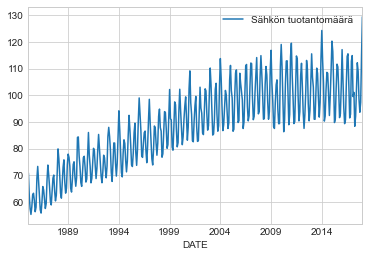

In [4]:
df = df.rename(columns = {'IPG2211A2N': 'Sähkön tuotantomäärä'})
df.plot()

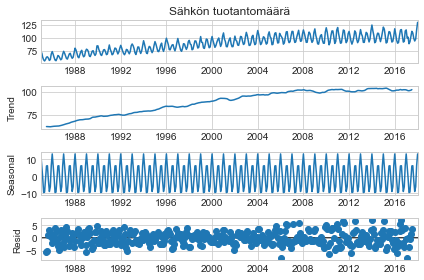

In [5]:
# Aikasarjan vaihtelua aiheuttavien komponenttien erottelu
# Observed=alkuperäinen aikasarja, Trend=trendi, Seasonal=kausivaihtelu,
# Residual=muu kuin trendiin ja kausivaihteluun liittyvä vaihtelu
# Alimmassa aikasarjassa on selvästi havaittavat trendi ja kausivaihtelu. Koska kyse on vuorokausidatasta, niin kausivaihtelu esiintyy neljän havainnon (40 päivän) jaksoissa.
decompose = seasonal_decompose(df['Sähkön tuotantomäärä']).plot()

In [10]:
#Mallin sovitus
#Ennustemalli sovitetaan (fit()) dataan. Tuloksena saadaan olio (tässä olen antanut oliolle nimeksi malli), joka sisältää monenlaista tietoa mallista.
#Trendiin (trend) käytän summamallia (add), jossa trendi on aikasarjaan lisättävä termi. Tämä on suositeltavin vaihtoehto.
#Kausivaihteluun (seasonal) käytän summamallia (add) tai tulomallia (mul). Tulomallissa kausivaihtelu ilmenee kertoimina. Tässä olen kokeillut myös summamallia, mutta tulomalli osoittautui paremmaksi.
#seasonal_periods-parametrille käytän arvoa 4, koska kausivaihtelu esiintyy neljän vuosineljänneksen jaksoissa.
#freq-parametrille käytän arvoa 'MS', koska kyseessä ovat kuukauden ensimmäiset päivät. Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
malli = ExponentialSmoothing(df['Sähkön tuotantomäärä'], trend = 'add', seasonal = 'mul', 
                             seasonal_periods = 4, freq='MS').fit()

In [11]:
# malli-olion avulla saan mallin mukaan simuloidut ennusteet (fittedvalues) jo toteutuneille ajankohdille
df['Ennuste'] = malli.fittedvalues
df

,Sähkön tuotantomäärä,Ennuste
DATE,,
1985-01-01,72.5052,67.924443
1985-02-01,70.6720,71.628072
1985-03-01,62.4502,68.903545
1985-04-01,57.4714,62.486886
1985-05-01,55.3151,60.097463
...,...,...
2017-09-01,98.6154,109.704621
2017-10-01,93.6137,96.956928
2017-11-01,97.3359,94.710328


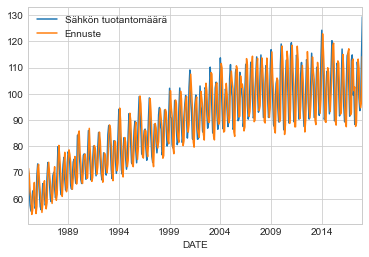

In [12]:
# Alkuperäinen aikasarja ja mallin mukaiset ennusteet samaan kaavioon
df.plot()

In [13]:
# Ennustevirheet (residuaalit) löytyvät malli-oliosta
df['Ennustevirhe'] = malli.resid
df

,Sähkön tuotantomäärä,Ennuste,Ennustevirhe
DATE,,,
1985-01-01,72.5052,67.924443,4.580757
1985-02-01,70.6720,71.628072,-0.956072
1985-03-01,62.4502,68.903545,-6.453345
1985-04-01,57.4714,62.486886,-5.015486
1985-05-01,55.3151,60.097463,-4.782363
...,...,...,...
2017-09-01,98.6154,109.704621,-11.089221
2017-10-01,93.6137,96.956928,-3.343228
2017-11-01,97.3359,94.710328,2.625572


Text(0, 0.5, 'Ennustevirhe')

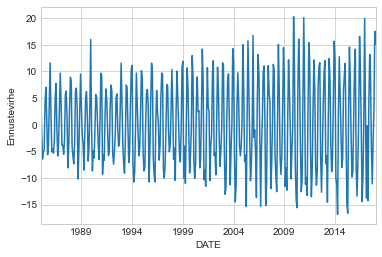

In [14]:
#Mallin tarkastelu
#Mallin hyvyyden tarkasteluun on monia tapoja. Tässä käytän
#ennustevirheiden aikasarjaa viivakaaviona
#ennusteiden ja toteutuneiden arvojen hajontakaaviota
#malliin liittyvää statistiikkaa, jonka saan summary()-toiminnolla.
#Huomaa erityisesti SSE (sum of squared errors). Mallia laskeva algoritmi yrittää saada SSE:n mahdollisimman pieneksi.
# Ennustevirheet aikasarjana
# On hyvä, jos ennustevirheiden aikasarjan vaihtelu on sattumanvaraista
df['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

Text(0, 0.5, 'Toteutunut kysyntä')

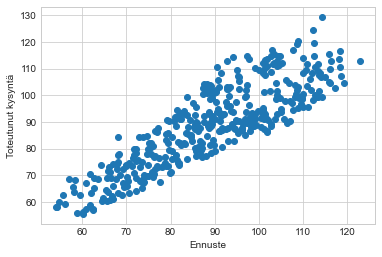

In [15]:
# Ennusteiden ja toteutuneiden kysyntöjen hajontakaavio
# Ennustemalli on sitä parempi, mitä paremmin pisteet seuraavat suoraa viivaa
# vasemmasta alakulmasta oikeaan yläkulmaan
plt.scatter(x = df['Ennuste'], y = df['Sähkön tuotantomäärä'])
plt.xlabel('Ennuste')
plt.ylabel('Toteutunut kysyntä')

In [16]:
malli.summary()

Dep. Variable:,endog,No. Observations:,397
Model:,ExponentialSmoothing,SSE,26874.423
Optimized:,True,AIC,1689.353
Trend:,Additive,BIC,1721.224
Seasonal:,Multiplicative,AICC,1689.923
Seasonal Periods:,4,Date:,"Fri, 15 Jan 2021"
Box-Cox:,False,Time:,16:10:47
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9473685,alpha,True
smoothing_slope,0.0526315,beta,True


In [17]:
#Ennusteiden laskeminen
#Ennustettavien ajankohtien aikaleimojen määrittämiseksi:
#Ensimmäisen ennustettavan ajankohdan aikaleiman täytyy olla aikasarjan viimeisintä aikaleimaa seuraava aikaleima.
#Ennustettavien ajankohtien lukumäärän voin määrittää periods-parametrilla.
#Ennustettavien ajankohtien frekvenssin on oltava sama kuin mallia sovitettaessa käytetty freq-parametrin arvo.
#Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
#Tarkistan viimeisen aikaleiman
df.tail()

,Sähkön tuotantomäärä,Ennuste,Ennustevirhe
DATE,,,
2017-09-01,98.6154,109.704621,-11.089221
2017-10-01,93.6137,96.956928,-3.343228
2017-11-01,97.3359,94.710328,2.625572
2017-12-01,114.7212,97.183615,17.537585
2018-01-01,129.4048,114.258588,15.146212


In [18]:
# Ennustettavien ajankohtien aikaleimat (alkupäivänä aikasarjan viimeistä aikaleimaa seuraava aikaleima)
index = pd.date_range('2018-02-01', periods = 12, freq = 'MS')

# Ennusteet 12 kuukaudelle
ennusteet = malli.forecast(12)

# Ennusteet dataframeen
df_ennuste = pd.DataFrame(data = ennusteet, index = index, 
                          columns = ['Ennuste'])
df_ennuste

,Ennuste
2018-02-01,127.775012
2018-03-01,131.357017
2018-04-01,134.132070
2018-05-01,134.060927
2018-06-01,133.136170
2018-07-01,136.811256
2018-08-01,139.644314
2018-09-01,139.514221
2018-10-01,138.497327
2018-11-01,142.265494


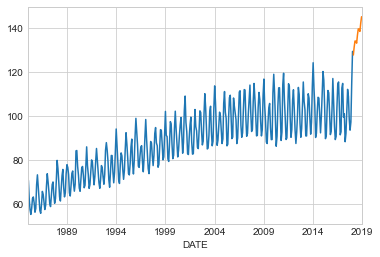

In [19]:
# Viivakaavio havainnoista
df['Sähkön tuotantomäärä'].plot()

# Ennusteet kaavioon
df_ennuste['Ennuste'].plot()

In [20]:
# Dataframe, jossa alkuperäinen aikasarja ja lasketut ennusteet
df1 = pd.concat([df, df_ennuste])
df1

,Sähkön tuotantomäärä,Ennuste,Ennustevirhe
1985-01-01,72.5052,67.924443,4.580757
1985-02-01,70.6720,71.628072,-0.956072
1985-03-01,62.4502,68.903545,-6.453345
1985-04-01,57.4714,62.486886,-5.015486
1985-05-01,55.3151,60.097463,-4.782363
...,...,...,...
2018-09-01,NaN,139.514221,NaN
2018-10-01,NaN,138.497327,NaN
2018-11-01,NaN,142.265494,NaN
2018-12-01,NaN,145.156559,NaN
